# Predicting house prices using linear regression
The goal of this project is to predict house sale prices from information regarding the property using a linear regression model. The data used can be found [here](http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls). It consists of 2930 entries about houses in Ames, Iowa.
Steps:
* Reading and cleaning data of missing values and useless columns
* Engineering additional useable features from existing columns
* Selecting the best numerical features using correlation and variance values
* Selecting the best categorical features by counting unique values and encoding dummy columns
* Training and testing the linear regression model using different validation methods

## Reading and cleaning the data
### Reading the data

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
data = pd.read_csv('AmesHousing.tsv', delimiter = '\t')
print(data.info(), '\n')
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


### Removing columns with too many missing values
Let's begin the data cleaning by removing columns with more than 5% missing values.

In [78]:
data_pruned = data.copy()

missing_values_ratio = data_pruned.isnull().sum() / len(data_pruned)
cols_to_drop = missing_values_ratio[missing_values_ratio > 0.05].index

data_pruned = data_pruned.drop(cols_to_drop, axis=1)
print(data_pruned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 71 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Area           2930 non-null int64
Street             2930 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         2930 non-null object
Roof Matl          2930 non-null object
Exterior 1st       29

### Filling in columns with few missing values
For columns with less than 5% missing data (and more than 0), we can fill in with the most frequent value of that column (the mode).

In [79]:
missing_values_ratio = data_pruned.isnull().sum() / len(data_pruned)
cols_to_fill = missing_values_ratio[(missing_values_ratio < 0.05) & (missing_values_ratio >0)].index

most_common_values = data_pruned[cols_to_fill].mode().to_dict(orient='records')[0]
data_pruned[cols_to_fill] = data_pruned[cols_to_fill].fillna(most_common_values)
print(data_pruned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 71 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Area           2930 non-null int64
Street             2930 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         2930 non-null object
Roof Matl          2930 non-null object
Exterior 1st       29

### Removing useless columns
Some columns dont help with the model, while others carry or contaminate the same information as the price column, which we are trying to predict.

In [80]:
data_pruned = data_pruned.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type"], axis=1)
print(data_pruned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 66 columns):
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Area           2930 non-null int64
Street             2930 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         2930 non-null object
Roof Matl          2930 non-null object
Exterior 1st       2930 non-null object
Exterior 2nd       2930 non-null object
Mas Vnr Type       

## Feature engineering
We can create new columns from existing ones to carry additional insights into our model.
* The difference between the year sold and year built can be a useful feature
* The difference between the year sold and the year remodeled can be a useful feature

In [81]:
data_pruned['Years Before Sale'] = data_pruned['Yr Sold'] - data_pruned['Year Built']
data_pruned['Years Since Remod'] = data_pruned['Yr Sold'] - data_pruned['Year Remod/Add']
data_pruned = data_pruned.drop(["Year Built", "Year Remod/Add", "Yr Sold"], axis = 1)

In [82]:
years_b_sale = data_pruned['Years Before Sale'] 
print(years_b_sale[years_b_sale<0])
years_b_remod = data_pruned['Years Since Remod'] 
print(years_b_remod[years_b_remod<0])

2180   -1
Name: Years Before Sale, dtype: int64
1702   -1
2180   -2
2181   -1
Name: Years Since Remod, dtype: int64


This calculation has produced some inconsistent data, let's remove those rows.

In [83]:
data_pruned = data_pruned.drop([1702, 2180, 2181], axis=0)
years_b_sale = data_pruned['Years Before Sale'] 
print(years_b_sale[years_b_sale<0])
years_b_remod = data_pruned['Years Since Remod'] 
print(years_b_remod[years_b_remod<0])

Series([], Name: Years Before Sale, dtype: int64)
Series([], Name: Years Since Remod, dtype: int64)


## Feature selection: Numerical Columns
Let's select the best columns to build the model on.

For numerical columns, we can use the correlation score, removing columns with low correlation, and columns that are correlated to each other (collinearity). We can also scale the data to identify colums with low variance that dont contribute meaningfully to the sale price and discard those.

### Selecting numerical columns with enough correlation to Sale Price

In [84]:
data_numerical = data_pruned.select_dtypes(include='number').copy()
correlation_coeffs = data_numerical.corr()['SalePrice'].abs().sort_values(ascending=False)
print(correlation_coeffs)

SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Years Before Sale    0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Wood Deck SF         0.328183
Open Porch SF        0.316262
Half Bath            0.284871
Bsmt Full Bath       0.276258
2nd Flr SF           0.269601
Lot Area             0.267520
Bsmt Unf SF          0.182751
Bedroom AbvGr        0.143916
Enclosed Porch       0.128685
Kitchen AbvGr        0.119760
Screen Porch         0.112280
Overall Cond         0.101540
MS SubClass          0.085128
Pool Area            0.068438
Low Qual Fin SF      0.037629
Bsmt Half Bath       0.035875
3Ssn Porch           0.032268
Misc Val             0.019273
BsmtFin SF 2         0.006127
Name: Sale

We will only keep columns with a correlation coeff greater than 0.45.

In [85]:
cols_to_keep = correlation_coeffs[correlation_coeffs>0.45].index
data_numerical = data_numerical[cols_to_keep]
print(data_numerical.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 13 columns):
SalePrice            2927 non-null int64
Overall Qual         2927 non-null int64
Gr Liv Area          2927 non-null int64
Garage Cars          2927 non-null float64
Total Bsmt SF        2927 non-null float64
Garage Area          2927 non-null float64
1st Flr SF           2927 non-null int64
Years Before Sale    2927 non-null int64
Full Bath            2927 non-null int64
Years Since Remod    2927 non-null int64
Mas Vnr Area         2927 non-null float64
TotRms AbvGrd        2927 non-null int64
Fireplaces           2927 non-null int64
dtypes: float64(4), int64(9)
memory usage: 320.1 KB
None


### Removing colinear numerical columns
Some columns carry the same information. They can be identified easily by visualizing their colinearity.

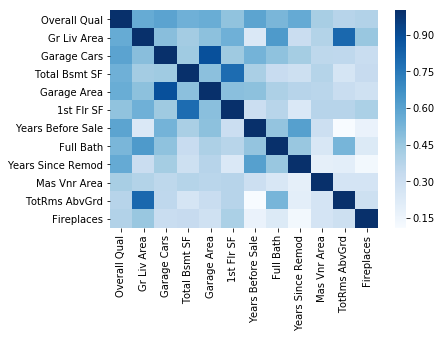

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.heatmap(data_numerical.drop('SalePrice', axis=1).corr().abs(), cmap='Blues')

It seems that Gr Liv Area and Roms Abg Grnd are strongly correlated, as expected. Similarly, Garage area and cars provide the same information. 
Let's keep the continuous value column for both these cases, and drop the other, to increase the performance of our model.

In [87]:
data_numerical = data_numerical.drop(['TotRms AbvGrd', 'Garage Cars'], axis=1)

### Inspecting variance of remaining numerical columns
A feature wont be very useful except to make the model slower if all or most of the entries have the same value. We can identify these features by normalizing the data on its minima and maxima and calculating the variance of each column.

In [88]:
# normalize the data
data_unit = (data_numerical - data_numerical.min())/(data_numerical.max() - data_numerical.min())

variances = data_unit.var().sort_values()
print(variances)

Total Bsmt SF        0.005022
1st Flr SF           0.007742
Gr Liv Area          0.008794
SalePrice            0.011593
Mas Vnr Area         0.012250
Full Bath            0.019077
Garage Area          0.020827
Overall Qual         0.024461
Fireplaces           0.026216
Years Before Sale    0.049585
Years Since Remod    0.120806
dtype: float64


Let's remove the three columns that have the lowest variance, below 0.01.

In [89]:
cols_to_keep = variances[variances>0.01].index
data_numerical = data_numerical[cols_to_keep]
print(data_numerical.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 8 columns):
SalePrice            2927 non-null int64
Mas Vnr Area         2927 non-null float64
Full Bath            2927 non-null int64
Garage Area          2927 non-null float64
Overall Qual         2927 non-null int64
Fireplaces           2927 non-null int64
Years Before Sale    2927 non-null int64
Years Since Remod    2927 non-null int64
dtypes: float64(2), int64(6)
memory usage: 205.8 KB
None


## Feature Selection: Categorical Columns
For categorical columns, we can convert them to useable form using dummy encoding, provided they do not have too many different values (which would result in too many additional columns to the model). Let's find out which are good candidates.

In [90]:
data_categorical = data_pruned.select_dtypes(include=['object']).copy()
print(data_categorical.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 32 columns):
MS Zoning         2927 non-null object
Street            2927 non-null object
Lot Shape         2927 non-null object
Land Contour      2927 non-null object
Utilities         2927 non-null object
Lot Config        2927 non-null object
Land Slope        2927 non-null object
Neighborhood      2927 non-null object
Condition 1       2927 non-null object
Condition 2       2927 non-null object
Bldg Type         2927 non-null object
House Style       2927 non-null object
Roof Style        2927 non-null object
Roof Matl         2927 non-null object
Exterior 1st      2927 non-null object
Exterior 2nd      2927 non-null object
Mas Vnr Type      2927 non-null object
Exter Qual        2927 non-null object
Exter Cond        2927 non-null object
Foundation        2927 non-null object
Bsmt Qual         2927 non-null object
Bsmt Cond         2927 non-null object
Bsmt Exposure     2927 non-null obj

### Selecting categorical columns with few enough unique entries
Categorical columns must have a limited number of entries to be useable in our model. To keep the size of the model in check, let's only keep the categorical values that have less than 5 unique entries, such that only 5 additional features will be created with dummy encoding.

In [91]:
unique_values = data_categorical.apply(lambda col: len(col.value_counts()))
unique_values

MS Zoning          7
Street             2
Lot Shape          4
Land Contour       4
Utilities          3
Lot Config         5
Land Slope         3
Neighborhood      28
Condition 1        9
Condition 2        8
Bldg Type          5
House Style        8
Roof Style         6
Roof Matl          8
Exterior 1st      16
Exterior 2nd      17
Mas Vnr Type       5
Exter Qual         4
Exter Cond         5
Foundation         6
Bsmt Qual          5
Bsmt Cond          5
Bsmt Exposure      4
BsmtFin Type 1     6
BsmtFin Type 2     6
Heating            6
Heating QC         5
Central Air        2
Electrical         5
Kitchen Qual       5
Functional         8
Paved Drive        3
dtype: int64

In [92]:
cols_to_drop = unique_values[unique_values > 5].index
data_categorical = data_categorical.drop(cols_to_drop, axis=1)
print(data_categorical.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 18 columns):
Street           2927 non-null object
Lot Shape        2927 non-null object
Land Contour     2927 non-null object
Utilities        2927 non-null object
Lot Config       2927 non-null object
Land Slope       2927 non-null object
Bldg Type        2927 non-null object
Mas Vnr Type     2927 non-null object
Exter Qual       2927 non-null object
Exter Cond       2927 non-null object
Bsmt Qual        2927 non-null object
Bsmt Cond        2927 non-null object
Bsmt Exposure    2927 non-null object
Heating QC       2927 non-null object
Central Air      2927 non-null object
Electrical       2927 non-null object
Kitchen Qual     2927 non-null object
Paved Drive      2927 non-null object
dtypes: object(18)
memory usage: 434.5+ KB
None


### Selecting categorical columns with high enough variance
We still want to remove low variance features, just like numerical columns. To determine the variance of these categorical columns, and eliminate the ones that have low variance, we can identify if any have 95% of the values belonging to the same category.

In [93]:
cols_to_drop = []
for col in data_categorical.columns:
    values = data_categorical[col].value_counts()
    if (values.max() / values.sum())>.95:
        cols_to_drop.append(col)
        
cols_to_drop

['Street', 'Utilities', 'Land Slope']

In [94]:
data_categorical = data_categorical.drop(cols_to_drop, axis=1)
print(data_categorical.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 15 columns):
Lot Shape        2927 non-null object
Land Contour     2927 non-null object
Lot Config       2927 non-null object
Bldg Type        2927 non-null object
Mas Vnr Type     2927 non-null object
Exter Qual       2927 non-null object
Exter Cond       2927 non-null object
Bsmt Qual        2927 non-null object
Bsmt Cond        2927 non-null object
Bsmt Exposure    2927 non-null object
Heating QC       2927 non-null object
Central Air      2927 non-null object
Electrical       2927 non-null object
Kitchen Qual     2927 non-null object
Paved Drive      2927 non-null object
dtypes: object(15)
memory usage: 365.9+ KB
None


### Encoding categorical columns into dummy columns

In [95]:
for col in data_categorical.columns:
    data_categorical[col] = data_categorical[col].astype('category')
    col_dummies = pd.get_dummies(data_categorical[col], prefix=col)
    data_categorical = pd.concat([data_categorical, col_dummies], axis=1)
    del data_categorical[col]

print(data_categorical.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 66 columns):
Lot Shape_IR1           2927 non-null uint8
Lot Shape_IR2           2927 non-null uint8
Lot Shape_IR3           2927 non-null uint8
Lot Shape_Reg           2927 non-null uint8
Land Contour_Bnk        2927 non-null uint8
Land Contour_HLS        2927 non-null uint8
Land Contour_Low        2927 non-null uint8
Land Contour_Lvl        2927 non-null uint8
Lot Config_Corner       2927 non-null uint8
Lot Config_CulDSac      2927 non-null uint8
Lot Config_FR2          2927 non-null uint8
Lot Config_FR3          2927 non-null uint8
Lot Config_Inside       2927 non-null uint8
Bldg Type_1Fam          2927 non-null uint8
Bldg Type_2fmCon        2927 non-null uint8
Bldg Type_Duplex        2927 non-null uint8
Bldg Type_Twnhs         2927 non-null uint8
Bldg Type_TwnhsE        2927 non-null uint8
Mas Vnr Type_BrkCmn     2927 non-null uint8
Mas Vnr Type_BrkFace    2927 non-null uint8
Mas Vnr Type_

## Combining the data
We can now combine our numerical and categorical features.

In [96]:
final_data = pd.concat([data_numerical, data_categorical], axis=1)
features = final_data.columns.drop("SalePrice")
target = 'SalePrice'
print(final_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 74 columns):
SalePrice               2927 non-null int64
Mas Vnr Area            2927 non-null float64
Full Bath               2927 non-null int64
Garage Area             2927 non-null float64
Overall Qual            2927 non-null int64
Fireplaces              2927 non-null int64
Years Before Sale       2927 non-null int64
Years Since Remod       2927 non-null int64
Lot Shape_IR1           2927 non-null uint8
Lot Shape_IR2           2927 non-null uint8
Lot Shape_IR3           2927 non-null uint8
Lot Shape_Reg           2927 non-null uint8
Land Contour_Bnk        2927 non-null uint8
Land Contour_HLS        2927 non-null uint8
Land Contour_Low        2927 non-null uint8
Land Contour_Lvl        2927 non-null uint8
Lot Config_Corner       2927 non-null uint8
Lot Config_CulDSac      2927 non-null uint8
Lot Config_FR2          2927 non-null uint8
Lot Config_FR3          2927 non-null uint8
Lot Confi

## Building the Linear Regression Model
We are now ready to begin the training and testing of the model. 
### Linear regression with holdout validation
The simplest way to begin is to split the data into 2 parts, for training and testing, and calculate the resulting Root Mean Square Error on the testing set.

In [97]:
train = final_data[:1460]
test = final_data[1460:]
lm = LinearRegression()
lm.fit(train[features], train[target])
rmse = mean_squared_error(lm.predict(test[features]), test[target])**0.5
rmse

35575.99662750925

### Simple Cross validation
Let's see if we can improve our score by using cross validation, in which the two halves are used as training and testing alternatively. This should reduce overfitting of the model to the training data.

In [100]:
final_data_shuffled = final_data.sample(frac=1)
fold_one = final_data[:1460]
fold_two = final_data[1460:]
lm = LinearRegression()

lm.fit(fold_one[features], fold_one[target])
rmse_1 = mean_squared_error(lm.predict(fold_two[features]), fold_two[target])**0.5

lm.fit(fold_two[features], fold_two[target])
rmse_2 = mean_squared_error(lm.predict(fold_one[features]), fold_one[target])**0.5

avg_rmse = (rmse_1+rmse_2) / 2
avg_rmse

33610.48023080897

### K-fold cross validation
We can go even further by using multiple folds in which the fraction of the data used to train is changed sequentially.

In [101]:
lm = LinearRegression()
kf = KFold(5, shuffle=True)
mses = cross_val_score(lm, final_data[features], final_data[target], cv=kf, scoring='neg_mean_squared_error')
sum((mses*-1)**.5) / len(mses)

33026.37908463852

Our error keeps reducing. Let's compare this to the actual price of houses to see how far off we are in our predictions, on average.

In [102]:
final_data['SalePrice'].mean()

180766.5664502904

The average house sale price is 181k, and the RMSE of our best performing model is 33k, or 18%. Not bad for a simple linear regression!
## Conclusion
Using the power of pandas and scikit, we were able to build a linear regression model from complex numerical and categorical data, to predict house sale prices with less than 20% error.